# COMP 551 Applied Machine Learning - Project 3

# Imports

In [ ]:
!pip install pickle5

from __future__ import print_function
import pickle5 as pickle
import numpy as np
import argparse
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import cv2

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import string

import random
from sklearn.utils import shuffle

import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 256 kB 5.4 MB/s 
Mounted at /content/drive


## Helper Functions

In [ ]:
def show_img (x):
  plt.imshow(x.reshape((56, 56)), cmap=cm.Greys_r)
  plt.show()

def get_lab (y):
 output = []
 letter = list(string.ascii_lowercase)
 number  = list(string.digits)

 for i in range (10):
    if(y[i]==1):
      output.append(number[i])
      break

 for i in range (26):
    if (y[i+10]==1):
      output.append(letter[i])
      break

 return output

def extract_value (predict):
  l = predict.numpy()
  result = np.zeros_like(predict)
  result[np.argmax(l[0:10])] = 1
  result[np.argmax(l[10:36])+10] = 1
  return result


# Only with 1 dimension array
def verify (predict, label):
  result = extract_value(predict)
  return np.array_equal(result,label.numpy())


def augment(img,transform,quantity):
    for i in range(quantity):
        transformed = transform(img[i,0].unsqueeze_(0))
        transformed = transformed.unsqueeze_(0)
        img = torch.cat((img,transformed), dim=0)
    print(img.size())
    return img

def augment2(img,transform,quantity):
    for i in range(quantity):
        transformed = transform(img[i,0].unsqueeze_(0))
        transformed = transformed.unsqueeze_(0)
        img[i,0]=transformed[0,0]
    print(img.size())
    return img

## Create GPU device

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, the following should print a CUDA device
print(device)

cuda:0


## Data augmentation and preprocessing

In [ ]:
#Using original labeles training data
with open("/content/drive/MyDrive/images_l.pkl", 'rb') as f: data_load = pickle.load(f)
with open("/content/drive/MyDrive/labels_l.pkl", 'rb') as f: labels_data = pickle.load(f)


np.random.seed(6)
x_train, labels_train= shuffle(np.array(data_load), np.array(labels_data))

#Splitting the data into three, one part to rotate only, another to blurr only,  a third to rotate and blurr
x_train1 = np.array(x_train[:9933,:])
x_train2 = np.array(x_train[9933:19866,:])
x_train3= np.array(x_train[19866:,:])

labels_train1=np.array(labels_train[:9933,:])
labels_train2=np.array(labels_train[9933:19866,:])
labels_train3=np.array(labels_train[19866:,:])


#Augment entire dataset
augment_quantity = 30000

#Rotate
loader_transform1= transforms.RandomRotation(degrees = 20,fill=0)
#Blurr
loader_transform2= transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.5, 0.66))

    
labels_train1=np.append(labels_train1,np.array(labels_train1[:augment_quantity,:]),axis=0)
labels_train2=np.append(labels_train2,np.array(labels_train2[:augment_quantity,:]),axis=0)
labels_train3=np.append(labels_train3,np.array(labels_train3[:augment_quantity,:]),axis=0)


with torch.no_grad():
  # Transform train to torch tensor and augment
  x_train1 = torch.from_numpy(x_train1).float().unsqueeze_(1)
  x_train2 = torch.from_numpy(x_train2).float().unsqueeze_(1)
  x_train3 = torch.from_numpy(x_train3).float().unsqueeze_(1)

  # Augment
  x_train1 = augment(x_train1,loader_transform1,augment_quantity)
  x_train2=augment(x_train2,loader_transform2,augment_quantity)
  x_train3=augment(x_train3,loader_transform1,augment_quantity)
  augment2(x_train3,loader_transform2,augment_quantity)

  x_train=torch.cat((x_train1,x_train2,x_train3), dim=0)

  show_img(x_train1[0,0])
  show_img(x_train1[9933,0])

  show_img(x_train2[0,0])
  show_img(x_train2[9933,0])


  show_img(x_train3[0,0])
  show_img(x_train3[10134,0]) 

  #Normalizing
  x_train=torch.div(x_train,255)

  #Transofrming labels to tensors and concatenating
  labels_train1 = torch.from_numpy(labels_train1).float()
  labels_train2 = torch.from_numpy(labels_train2).float()
  labels_train3 = torch.from_numpy(labels_train3).float()

  labels_train=torch.cat((labels_train1,labels_train2,labels_train3), dim=0)


  # Saving augmented dataset
  with open('/content/drive/MyDrive/551 P3/aug20blurrm_f_x_train.pkl', 'wb') as f:
    pickle.dump(x_train, f)

  labels_train = torch.from_numpy(labels_train).float()

  with open('/content/drive/MyDrive/551 P3/aug20blurrm_f_l_train.pkl', 'wb') as f:
    pickle.dump(labels_train, f)

  


## Loading and normalizing image data

In [ ]:
#Using augmented training data
with open("/content/drive/MyDrive/551 P3/aug20full_x_train.pkl", 'rb') as f: data_load = pickle.load(f)
with open("/content/drive/MyDrive/551 P3/aug20full_l_train.pkl", 'rb') as f: labels_data = pickle.load(f)
with open("/content/drive/MyDrive/images_test.pkl", 'rb') as f: test_data=pickle.load(f)
with open("/content/drive/MyDrive/images_ul.pkl", 'rb') as f: unlabeled_data=pickle.load(f)


np.random.seed(5)
torch.manual_seed(0)
random.seed(0)

x_train, labels_train= shuffle(np.array(data_load), np.array(labels_data))

#Trainining set
x_train = np.array(data_load[:58000,:])
labels_train=np.array(labels_data[:58000,:])

#Validiation set
x_test=np.array(data_load[58000:,:])
labels_test = np.array(labels_data[58000:,:])

#Test data
test_data=np.array(test_data)


with torch.no_grad():
  # Transform training data to torch tensor
  x_train = torch.from_numpy(x_train).float()
  labels_train = torch.from_numpy(labels_train).float()

  # Transform validation data to torch tensors
  x_test = torch.from_numpy(x_test).float()
  labels_test = torch.from_numpy(labels_test).float()

  # Transform validation data to torch tensors
  test_data=torch.from_numpy(test_data).float().unsqueeze_(1)
  # Normalizing test data
  test_data=torch.divide(test_data,255)

  train_set= torch.utils.data.TensorDataset(x_train, labels_train)
  train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)

  test_set = torch.utils.data.TensorDataset(x_test, labels_test)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True, num_workers=2)

  test_images= torch.utils.data.TensorDataset(test_data)
  kaggle_loader=torch.utils.data.DataLoader(test_images,batch_size=1,shuffle=False,num_workers=2)

<class 'torch.Tensor'>
(60000, 1, 56, 56)
torch.Size([58000, 1, 56, 56])


## CNN Architecture
The first one is LeNet one and the second is our variant of VGG16

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5 )
        self.conv2 = nn.Conv2d(32, 32, 5, bias=False)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 64, 3, bias=False)
        
        self.batch1 = nn.BatchNorm2d(32)
        self.batch2 = nn.BatchNorm2d(64)

        self.batch3 = nn.BatchNorm1d(1024)
        self.batch4 = nn.BatchNorm1d(512)
        self.batch5 = nn.BatchNorm1d(336)

        self.drop = nn.Dropout2d(p=0)
        self.pool = nn.MaxPool2d(2, stride=2)
                
        self.fc1 = nn.Linear(6400, 1024,bias=False) 
        self.fc2 = nn.Linear(1024, 512, bias=False)
        self.fc3 = nn.Linear(512, 336, bias=False)
        self.fc4 = nn.Linear(336, 36)
  

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.conv2(x)
        x = F.relu(self.batch1(x))
        x = self.pool(x)
        x = self.drop(x)
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        x = F.relu(self.batch2(x))
        x = self.pool(x)
        x = self.drop(x)
        x = x.view(-1, 6400)
        x = F.relu(self.batch3(self.fc1(x)))
        x = F.relu(self.batch4(self.fc2(x)))
        x = F.relu(self.batch5(self.fc3(x)))
        x = self.drop(x)
        x = self.fc4(x)
        return x

# Uncomment for training neural network
'''net = Net().to(device)

# Define a loss function and optimizer

# Criterion to calculate the loss 
criterion = nn.CrossEntropyLoss().to(device)

# Optimiser set up
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

# Function that will reduce the learning rate of the optimizer if the loss function stagnates
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.2, patience=2)'''


"net = Net().to(device)\nprint(net)\n\n# Define a loss function and optimizer\n\n# Criterion to calculate the loss \ncriterion = nn.CrossEntropyLoss().to(device)\n\n# Optimiser set up\noptimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)\n\n# Function that will reduce the learning rate of the optimizer if the loss function stagnates\nscheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.2, patience=2)"

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)     #start
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1, bias=False)    #56x56
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)   #56x56
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1, bias=False)  #28x28
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)  #28x28
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1, bias=False)  #14x14
        #self.conv7 = nn.Conv2d(256, 512, 3, padding=1)  #14x14
        #self.conv8 = nn.Conv2d(512, 512, 3, padding=1)  #7x7
        self.batch1 = nn.BatchNorm2d(128)
        self.batch2 = nn.BatchNorm2d(256)

        ####### Internal testing
        self.batch3 = nn.BatchNorm2d(256)
        self.batch4 = nn.BatchNorm1d(4096)
        #self.batch5 = nn.BatchNorm1d(84)



        #self.batch3 = nn.BatchNorm1d(1024)
        #self.batch4 = nn.BatchNorm1d(512)
        #self.batch5 = nn.BatchNorm1d(336)

        #self.drop = nn.Dropout2d(p=0.15)
        self.pool = nn.MaxPool2d(2, stride=2)
        
        ####### Internal testing
        #self.fc1 = nn.Linear(576, 256,bias=False) 
        #self.fc2 = nn.Linear(256, 128, bias=False)
        #self.fc3 = nn.Linear(128, 84, bias=False)
        #self.fc4 = nn.Linear(84, 10)

        
        self.fc1 = nn.Linear(256*7*7, 4096) 
        self.fc2 = nn.Linear(4096, 4096, bias=False)
        self.fc3 = nn.Linear(4096, 36)
        #self.fc4 = nn.Linear(336, 36)
        
        #self.out = nn.Sigmoid()
  

    def forward(self, x):
        #print(x.size())
        x = F.relu(self.conv1(x)) #1 to 64
        #print(x.size())
        x = F.relu(self.conv2(x)) #64 to 64
        x = F.relu(self.batch1(self.conv3(x))) #64 to 128
        #print(x.size())
        x = self.pool(x)          #pool
        #print(x.size())
        x = F.relu(self.conv4(x)) #128 to 128
        x = F.relu(self.conv4(x)) #128 to 128
        x = F.relu(self.batch3(self.conv5(x))) #128 to 256
        #print(x.size())
        x = self.pool(x)          #pool
        #print(x.size())
        x = F.relu(self.conv6(x)) #256 to 256
        x = F.relu(self.batch2(self.conv6(x))) #256 to 256
        #x = F.relu(self.conv7(x)) #256 to 512
        #print(x.size())
        x = self.pool(x)          #pool
        #print(x.size())
        #x = F.relu(self.conv8(x)) #512 to 512
        #x = F.relu(self.conv8(x)) #512 to 512
        #print(x.size())
        #x = self.pool(x)          #pool
        #print(x.size())
        #print("Going Linear", x.shape)
        ####### Internal testing
        #x = x.view(-1, 576) 
        #x = x.view(-1, 256*7*7)
        #print(x.size())
        x = torch.flatten(x,1)
        #print(x.size())
        x = F.relu(self.fc1(x))
        #print(x.size())
        x = F.relu(self.batch4(self.fc2(x)))
        #print(x.size())
        x = self.fc3(x)
        #print("Final", x.size())
        #x = self.out(x)
        return x

net = Net().to(device)
print(net)

# Define a loss function and optimizer

# Criterion to calculate the loss 
criterion = nn.CrossEntropyLoss().to(device)

# Optimiser set up
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0)

# Function that will reduce the learning rate of the optimizer if the loss function stagnates
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.2, patience=2)


In [ ]:
# Loading the model already trained. Create an instance of the model we want to load and the load the data it needs from our file
# Do not run if want to train the model
net = Net().to(device)
net.load_state_dict(torch.load('/content/drive/My Drive/551 P3/aug20deg_dropout0_14epochs_submit_net.pth'))
net.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch5): BatchNorm1d(336, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout2d(p=0, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6400, out_features=1024, bias=False)
 

## Training the network

In [ ]:
# Function to get validation accuracy
def get_acc(loader):
  net.eval()
  correct = 0
  total = 0
  with torch.no_grad():
      for data in loader:
          images, labels = data[0].to(device),data[1]
          outputs = net(images)
          predicted = outputs.cpu()
          for y_hat, y_true in zip(predicted, labels):
            total = total + 1
            if (verify(y_hat,y_true)):
              correct = correct + 1

  acc=100 * correct / total
  return acc

'  print(\'Accuracy: %d %%\' % (\n      100 * correct / total))\n  print("Number of correct predictions:  ", correct)'

In [ ]:
prev_loss = 100
net.train()
val_err=np.zeros(14)
j=0

for epoch in range(14):  # loop over the dataset multiple times

    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics during the training
        running_loss += loss.item()

        if i % 500 == 499:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 500))
            running_loss = 0.0


    # Print validation accuracy    
    val_err[j]=get_acc(test_loader)
    print("j=", j)
    print("validation acc is: ", val_err[j])

    net.train()
    j=j+1


#Save current model
print('Finished Training')
PATH = '/content/drive/My Drive/551 P3/aug20deg_dropout0_14epochs_submit_net.pth'
torch.save(net.state_dict(), PATH)


Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch5): BatchNorm1d(336, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout2d(p=0, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6400, out_features=1024, bias=False)
 

"# Save our trained model\nPATH = '/content/drive/My Drive/551 P3/aug10deg_net.pth'\ntorch.save(net.state_dict(), PATH)"

## Test the network on test data

[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0],

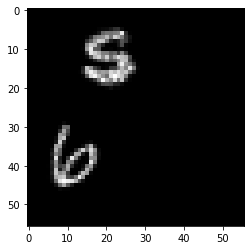

['6', 's']


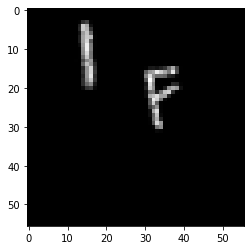

['1', 'f']


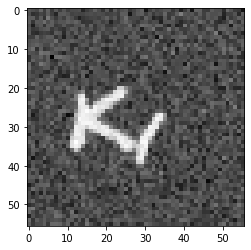

['4', 'k']


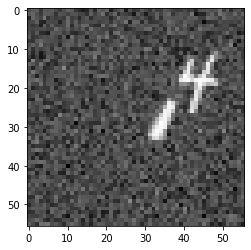

['4', 'i']


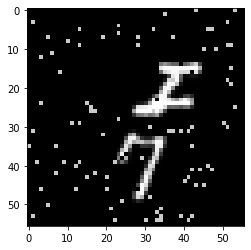

['7', 'i']


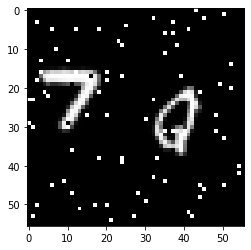

['7', 'q']


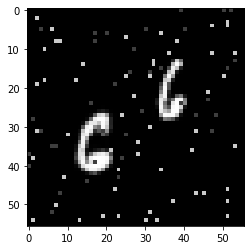

['6', 'g']


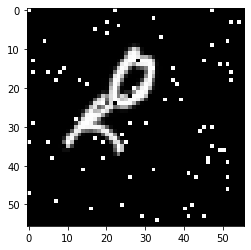

['0', 'k']


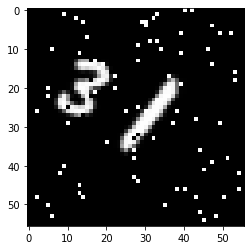

['3', 'i']


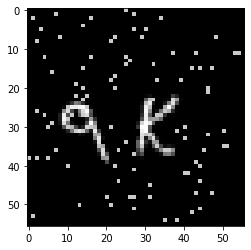

['9', 'k']


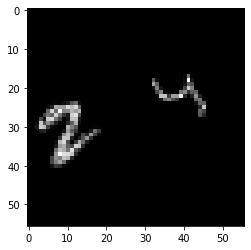

['4', 'z']


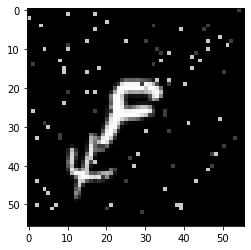

['4', 'f']


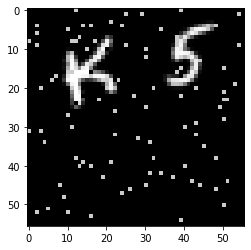

['5', 'k']


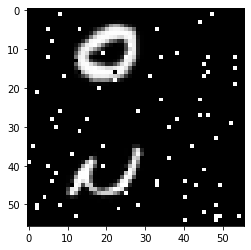

['0', 'n']


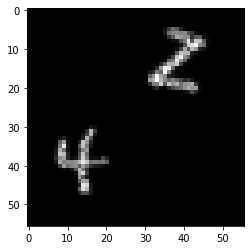

['4', 'z']


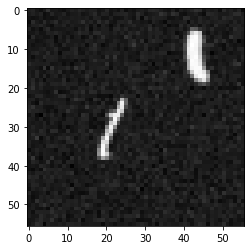

['1', 'l']


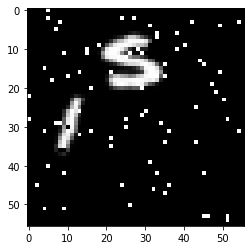

['1', 's']


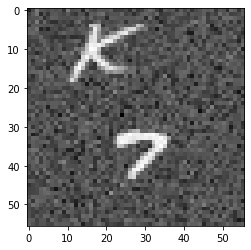

['7', 'k']


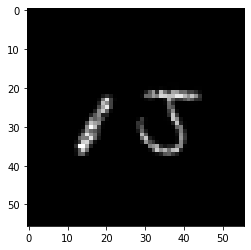

['1', 'j']
        # Id                              Category
0          0  000000100000000000000000000010000000
1          1  010000000000000100000000000000000000
2          2  000010000000000000001000000000000000
3          3  000010000000000000100000000000000000
4          4  000000010000000000100000000000000000
...      ...                                   ...
29995  29995  000001000000000000100000000000000000
29996  29996  001000000000000000000000000001000000
29997  29997  000001000000000001000000000000000000
29998  29998  000100000000100000000000000000000000
29999  29999  000000100000000001000000000000000000

[30000 rows x 2 columns]
Importing test predictions in csv --- check your 551 P3 folder


In [ ]:
# Get predictions on test data and save to csv file
def get_test_csv(loader):
  net.eval()
  correct = 0 
  total = 0
  i=0
  cols=2
  rows=15000
  res=[[0 for i in range(cols)] for j in range(rows)]
  print(res)
  print(len(res))
  with torch.no_grad():
      for data in loader:
          images = data[0].to(device)
          outputs = net(images)
          predicted = outputs.cpu()
          res[i][0]=str(i)
          int_arr=extract_value(predicted[0]).astype(dtype=int)
          str_arr=np.array2string(int_arr,separator="")
          res[i][1]=str_arr[1:37]
          i=i+1

                
  result_df=pd.DataFrame(res,columns=["# Id","Category"])
  # Exporting predictions to csv file
  result_df.to_csv('/content/drive/My Drive/551 P3/submission.csv',index=False)
  return result_df


print("Training accuracy ---- ",get_acc(train_loader))
print("Validation accuracy ---- ",get_acc(test_loader))
print("Getting predictions...")
result=get_test_csv(kaggle_loader)
print("Importing test predictions in csv --- check your 551 P3 folder")






In [ ]:
# Compares the two results of the unlabeled data from our two models. 
#If they agree for a specific label, we record the picture and the label so we can add them to the training set
df1 = pd.read_csv ('/content/drive/My Drive/comp551/unlabeled_VGG.csv')
df2 = pd.read_csv ('/content/drive/My Drive/comp551/unlabeled_Luis.csv')

unlabel_x = np.empty([24944,1,56,56])
unlabel_y = np.empty([24944,36])
count = 0
for index, row in df1.iterrows(): 
    if row['Category'] == df2.iloc[index]['Category']:
      true_label = list(row['Category'])
      results = [int(i) for i in true_label]
      unlabel_x[count][0] = (test_data[index][0])
      unlabel_y[count] = (results)
      count = count + 1

print(count)
print(unlabel_x.shape,unlabel_y.shape)